# Prediction the median price of houses in California districts

## Metadate

**Created by**: Arkadiusz Morawiec

**Date**: 29.06.2024 #DD.MM.YYYY

**Goal**: Predicting the houses median price basen od data

**Description**: This notebook describe step by step how to build a process prediction model.

**version**: 1.0

## Data information

Data comes from `StatLib` repository and are based on the 1990 California consus.

The goal of the project will be create a regression model to predict the district's median house price.

## Selection of models and metrics

**Models**:

In this project I will use the next regression models:
1. **Linear regression:** For simplicity and interpretablity.
2. **Decision Trees:** - To capture potential non-regresion relationship in the data
3. **Random Forest:** - To improve accuray and reduce overfitting.
4. **Gradient Boosting (XGBoost/CatBoost):** - For achieving high predicitve accuracy.

**Metrics**
To assess the performance of our models, we will use the following metrics:
1. **MAE (Mean Absolute Error):** - The average absolute difference between actual and predictive values.
2. **MSE (Mean Square Error)** - The average square difference between actual and predictive values.
3. **RMSE (Root Mean Squared Error** - The square root of MSE, interpreted as the typical prediction error.
4. **R^2 (Coefficient of Determination)** - The proportion of variance explained by the model.

## Setup Enviroment

In [143]:
# importing necessery libraries

## data preprocessing, read, transforming
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

## Models, Metrics, Processing, Encoders, Split data
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

import eli5

## ReadData

In [144]:
def readDataSet():
    from pathlib import Path
    Path = Path("../datasets/")
    file_name = "housing.csv"
    CaliforniaDf = pd.read_csv(Path.joinpath(file_name))
    return CaliforniaDf

In [145]:
df = readDataSet()

# Data Understanding

### Data desctiption

Dataset consists of 20640 entries and 10 columns:

1. **longitude** - A measure of how far west a house is
2. **latitude** - A measure of how far north a house is;
3. **housing_median_age** - Median age of a house within a block; a lower number is a newer building
4. **total_rooms** - Total number of rooms within a block
5. **total_bedrooms** - Total number of bedrooms within a block
6. **population** - Total number of people residing within a block
7. **households** - Total number of households, a grouop of people residin within a home unit for a block
8. **median_income** - Median income for household within a block of houses (measured in tens of thousands of US $)
9. **median_house_value** - Median house value for households with a block (measured in US Dollars)
10. **ocean_proximity** - Location of the house at a distance from ocean (category)

## First glance of data

In [146]:
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Check types

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In data set we have:

- 9 float feature: (Numerical)
    - Continous data:
        - longitude
        - latitude
        - median_income
        - median_house_value
    - Discrete:
        - housing_median_age
        - total_rooms
        - total_bedroms
        - population
        - households
- 1 object: (Categorical):
    - Oridinal:
        - ocean_proximity 

In [148]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [149]:
df.shape[0]

20640

## Check nulls

In [150]:
dfNulls = df.isnull().sum().to_frame(name='ct')
dfNulls['%'] = ((dfNulls['ct']/df.shape[0]) * 100.0).round(3)
dfNulls

,ct,%
longitude,0,0.000
latitude,0,0.000
housing_median_age,0,0.000
total_rooms,0,0.000
total_bedrooms,207,1.003
population,0,0.000
households,0,0.000
median_income,0,0.000
median_house_value,0,0.000
ocean_proximity,0,0.000


One variable has null values: **total_bedrooms** (207 : 1.003%)

## Check duplicates

In [151]:
df[df.duplicated(subset=['longitude','latitude','population','median_house_value'], keep=False)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity


**NO DUPLICATE ROWS IN DATASET**

## Basic stats

### Numeric Variables

In [152]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Longitude/Latitude**
- Probably no outliers, data is in cluster, mean is close to the median and std is insignificant+

**housing_median_age**: 
- Looking at median and mean it could be normal distribution. 
- A high value of deviation from the mean indicates data diversity. 
- large range of data suggest the occurrence of outlers

**total_rooms**:
- mean is highest than median so it suggets the distribution is right skrew.
- Outliers could occurence because range of data is much too big for std (range: 2-39320; std: 2181), 3std limit is: 2635 + 3*2181 = 9178

**total_bedrooms**:
- mean is higest then median so it suggets the distribution is right skrew.
- High value of deviation suggest large variance (we have range 1-6445))
- Outliers can occurence if we look at 75 percentile and we will compare it with the max value

**pupulation**
- mean is higest then median so it suggets the distribution is right long skrew.
- Outliers can occurence if we look at 75 percentile and we will compare it with the max value
- range 3-35682

**households**:
- mean is higest then median so it suggets the distribution is right long skrew.,
- Outliers can occurence if we look at 75 percentile and we will compare it with the max value

**median_income**
- mean is higest then median so it suggets the distribution is right skrew, but not much
- range is 0.5-15

**median_house_value:**
- mean is higest then median so it suggets the distribution is right skrew.
- high range 15k-500k

### Categorical Variables

In [153]:
df.describe(exclude='number')

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


We have only one Cat variable.

**ocean_proximity:**
- 5 unique values
- top (9136) is "1H OCENA"

# EDA (Exploratory Data Analysis)

In [154]:
df_org = df.copy() ## We create copies of the data because we will perform various transfroamtion to visualize the data

## Distribution of data

In [155]:
df.select_dtypes(['object','category']).columns

Index(['ocean_proximity'], dtype='object')

In [156]:
numerical_feautres = df.select_dtypes('number').columns
print(numerical_feautres)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')


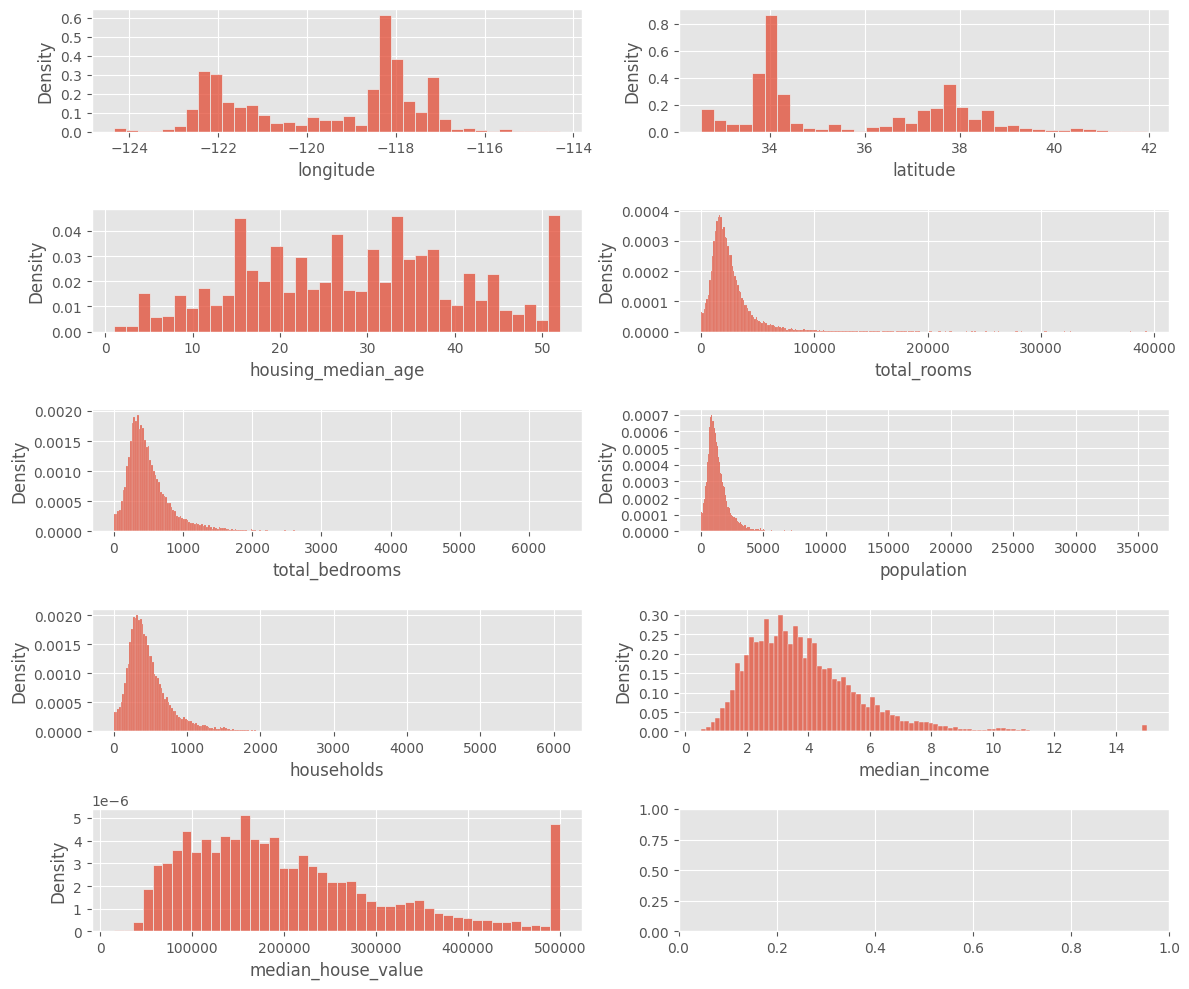

In [157]:
ncol = 2
nrows = len(numerical_feautres) // ncol + len(numerical_feautres) % ncol
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=(12,2*nrows))

axes = axes.flatten()

for ax, col in zip(axes, numerical_feautres):
    sns.histplot(df, x=col, ax=ax, stat='density')
    ax.locator_params(axis='both', nbins=8)

plt.tight_layout()
plt.show()

In area of **logitute** ~ -122/-118 and **latitude** ~35/37 we have clusters of houses. - We need to calculate rbf kernal from this clusters

**Housing_median_age** is multimodal data and probablity is clipped to ~51.

**Total rooms** is long right skrew distribution with a peak in the 2k area We need log10 if >0 or log1p if >=0

**Total bedrooms** long right skrew distribution with a peak in the ~280 value. We need log10...

**Households** Long right skrew distribution with a peak in the 450 values. We need log it

**Median income** short right skrew distribution. we can log it.

**Population** - Long right skrew distribution. Peak ~1k

**Median house value** short right skrew distribution with additional peak in last bucket, probably original data has been cliped






## Visualise map of points long and lat

In [158]:
df['Long_lat'] = df['longitude'].round(1).astype('str') + "," + df['latitude'].round(1).astype('str') ## Most freq points Long Lat
df['Long_lat'].value_counts().head(5)

Long_lat
-118.3,34.0    422
-118.2,34.0    360
-118.4,34.0    348
-122.2,37.8    291
-118.4,34.2    289
Name: count, dtype: int64

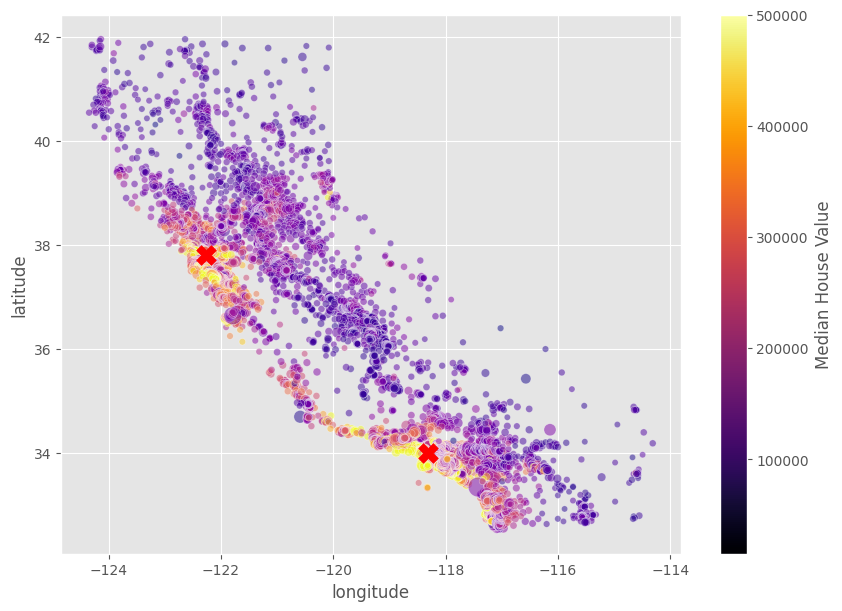

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 7))
plt.xticks
# Utworzenie osi dla wykresu
ax = plt.gca()

# Utworzenie wykresu scatter
scatter = sns.scatterplot(
    data=df,
    x="longitude",
    y="latitude",
    size=df["population"] / 100,
    sizes=(20, 200),
    hue="median_house_value",
    palette="plasma",
    ax=ax,
    legend=False,
    alpha=0.5
)

# Dodanie siatki (grid)
plt.grid(True)

# Dodanie paska kolorów (color bar)
norm = plt.Normalize(df["median_house_value"].min(), df["median_house_value"].max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])  # Wymagane tylko do utworzenia poprawnej skali kolorów
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Median House Value')

## add cluster from above conlusion
x = [-122.27,-118.31]
y = [37.8, 34]
plt.scatter(x=x, y=y, marker="X", color='red', s=200)


# Pokaż wykres
plt.show()



On the Scatter plot we can see few area with High median house value. Probably it will be good idea calculate `KNeighbourHood` or RBF kernel (distance from  the point ex. Big City like Los Angeles, Sandiego)

## Housing_median_age

Text(0.5, 0, 'housing median age')

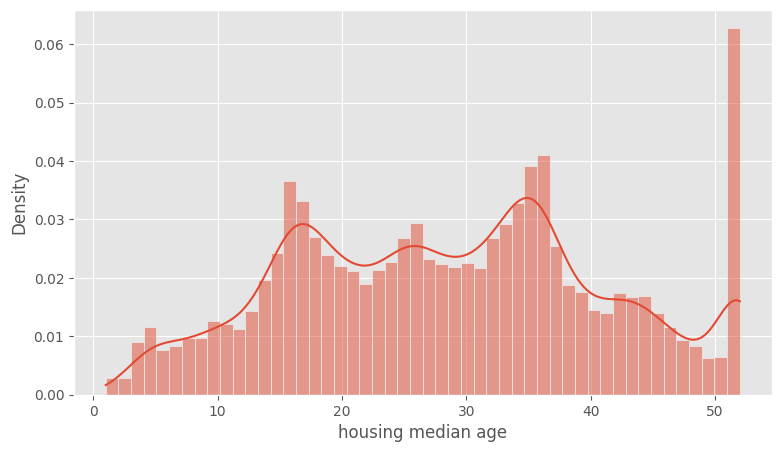

In [160]:

plt.figure(figsize=(9,5))
sns.histplot(data=df, x='housing_median_age', stat='density', bins=50, kde=True)
plt.xlabel('housing median age')

In [161]:
from sklearn.metrics.pairwise import rbf_kernel

age_similar_17 = rbf_kernel(df[['housing_median_age']], [[35]], gamma=0.1)

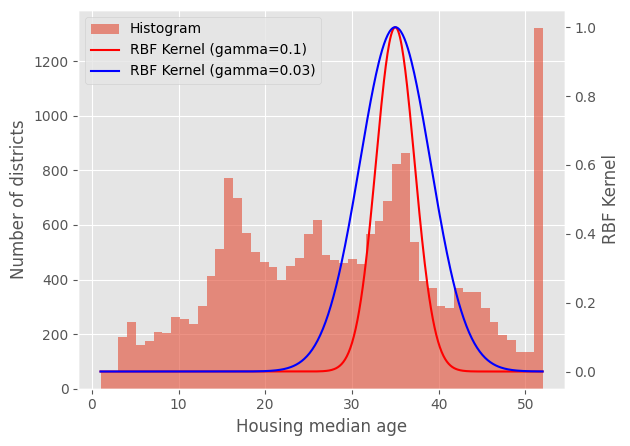

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

# Zakładam, że dane są wczytane do DataFrame o nazwie 'df'

ages = np.linspace(df['housing_median_age'].min(), df['housing_median_age'].max(), 500).reshape(-1, 1)

gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(df['housing_median_age'], bins=50, alpha=0.6, label='Histogram')

ax2 = ax1.twinx()
ax2.set_ylabel("RBF Kernel")

ax2.plot(ages, rbf1, color='red', label=f'RBF Kernel (gamma={gamma1})')
ax2.plot(ages, rbf2, color='blue', label=f'RBF Kernel (gamma={gamma2})')

plt.grid(False)
# Dostosowanie marginesów
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Dodatkowa przestrzeń na górze

fig.legend(loc="upper left",bbox_to_anchor=(0.00, 1), bbox_transform=ax1.transAxes)
plt.show()


## Visualise correlation matrix

<Axes: >

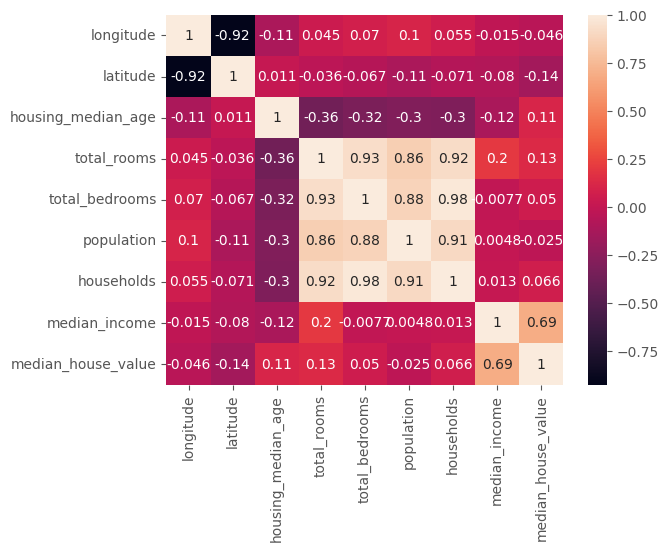

In [163]:
sns.heatmap(df.select_dtypes('number').corr(), annot=True)

**Conslusion**

1. Median income has nice linear correlation with median_house_value and it's only ones.
2. Total rooms and total bedroms has nice correlelation with population, so it's would be a good idea to create new features by using them
3. Households has a nice corr with total rooms, total bedrooms and population so again we can use it to calculate for ex. average number of citizens in the district

<Axes: xlabel='median_income', ylabel='median_house_value'>

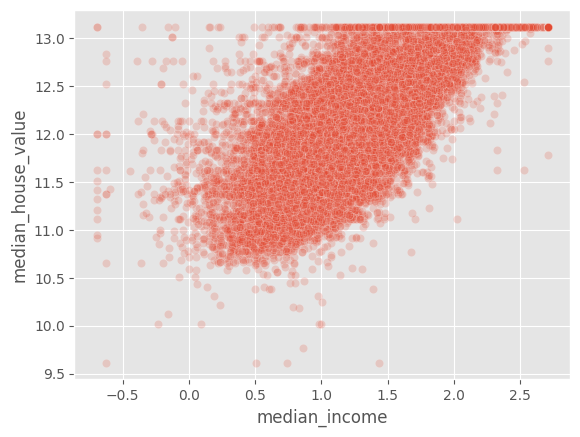

In [164]:
sns.scatterplot(data=df, x=np.log(df['median_income']), y=np.log(df['median_house_value']), alpha=0.2)

# Data Imputing 

In [165]:
df = df_org

num_feat = df.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='median')
imputer.fit(num_feat)

print("Statistics: \n", imputer.statistics_)



Statistics: 
 [-1.1849e+02  3.4260e+01  2.9000e+01  2.1270e+03  4.3500e+02  1.1660e+03
  4.0900e+02  3.5348e+00  1.7970e+05]


In [166]:
X_impute = imputer.transform(num_feat)
df_X_imputed = pd.DataFrame(X_impute, columns=num_feat.columns, 
                           index = num_feat.index)
df_X_imputed.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [167]:
df = df_X_imputed

# Feature Engineering

In [168]:
# lets calculate some meatrics using corrs features
def create_features(df):
    df = df.copy()
    df['avg_persons_per_house'] = df['population']/df['households']
    df['bedroom_ratio'] = df['total_bedrooms']/df['total_rooms']
    df['room_ratio'] = df['total_rooms']/df['households']
    
    return df

df = create_features(df)

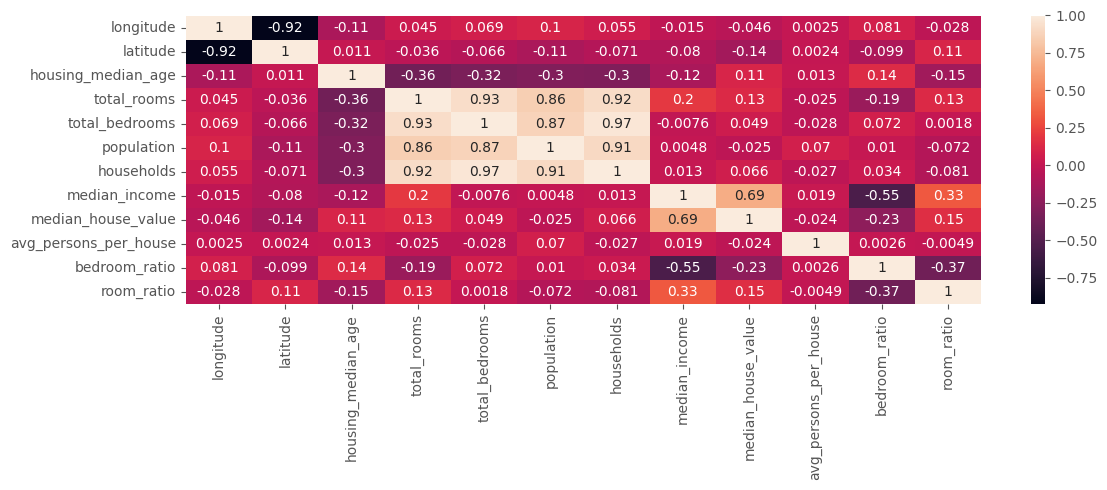

In [169]:
plt.figure(figsize=(12,5))
sns.heatmap(df.select_dtypes('number').corr(), annot=True)
plt.tight_layout()
plt.show()

In [170]:
san_fran_cords = np.array([[37.8, -122.27]])
los_angeles_cords = np.array([[34, -118.31]])

cords = df[['latitude', 'longitude']].values

gamma = 0.1

rbf_kernel_sf = rbf_kernel(cords, san_fran_cords, gamma=gamma)
rbf_kernel_la = rbf_kernel(cords, los_angeles_cords, gamma=gamma)

df['rbf_sf'] = rbf_kernel_sf.flatten()
df['rbf_la'] = rbf_kernel_la.flatten()


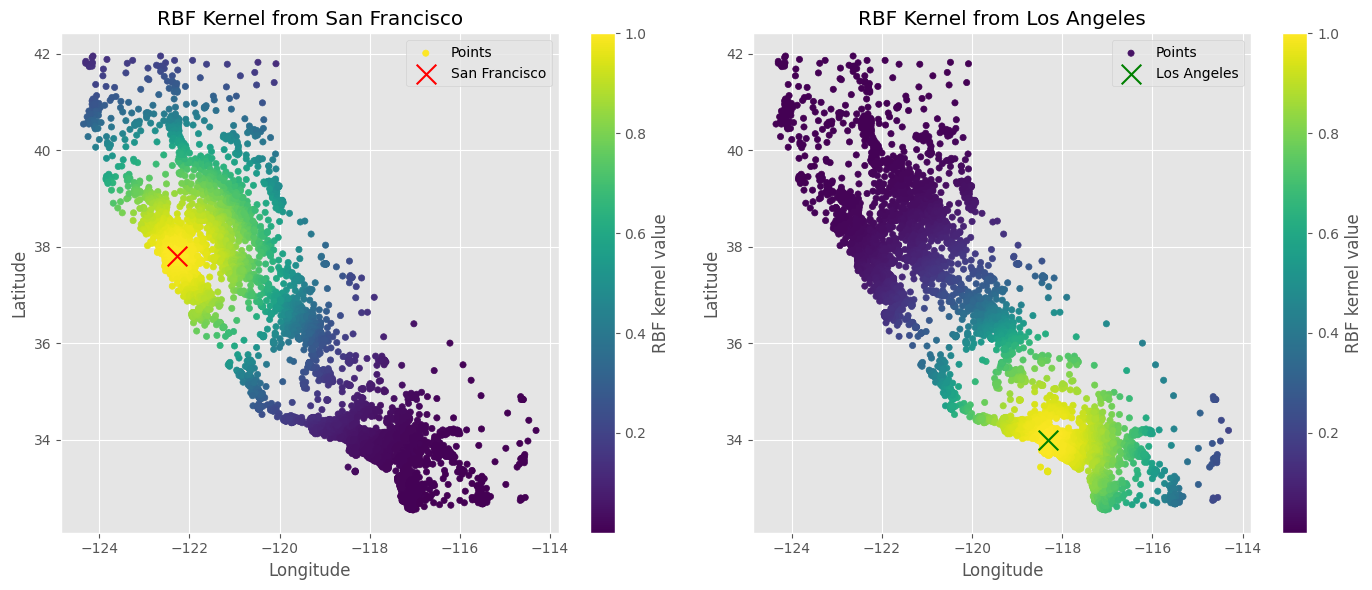

In [171]:
# Ustawienia wykresu
plt.figure(figsize=(14, 6))

# Wykres dla San Francisco
plt.subplot(1, 2, 1)
plt.scatter(df['longitude'], df['latitude'], c=df['rbf_sf'], cmap='viridis', label='Points', s=20)
plt.colorbar(label='RBF kernel value')
plt.scatter(san_fran_cords[0][1], san_fran_cords[0][0], c='red', label='San Francisco', marker='x', s=200)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('RBF Kernel from San Francisco')
plt.legend()
plt.grid(True)

# Wykres dla Los Angeles
plt.subplot(1, 2, 2)
plt.scatter(df['longitude'], df['latitude'], c=df['rbf_la'], cmap='viridis', label='Points', s=20)
plt.colorbar(label='RBF kernel value')
plt.scatter(los_angeles_cords[0][1], los_angeles_cords[0][0], c='green', label='Los Angeles', marker='x', s=200)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('RBF Kernel from Los Angeles')
plt.legend()
plt.grid(True)

# Wyświetlenie wykresów
plt.tight_layout()
plt.show()


In [205]:
hist, bin_edges = np.histogram(df['housing_median_age'].values, bins=50)

# find lokals peacks
from scipy.signal import find_peaks
peaks, _ = find_peaks(hist)

# gets maxima and index of it in hist
peak_values = hist[peaks]
peak_position = bin_edges[peaks].round(0)

# sort maxima
sorted_indices = np.argsort(peak_values)[::-1]
top_3_peaks = sorted_indices[:3]

# Wybór trzech największych mod
top_3_peaks = sorted_indices[:3]
top_3_modes = peak_position[top_3_peaks].reshape(-1,1)

top_3_modes

array([[36.],
       [15.],
       [25.]])

In [173]:
# Calculate rbf from the median house age

for mode in top_3_modes.tolist():
    df['median_age_simil_'+str(int(mode[0]))] = rbf_kernel(df[['housing_median_age']], [mode], gamma=0.1).flatten()

In [199]:
top_3_modes.reshape(1,3)

array([[36., 15., 25.]])

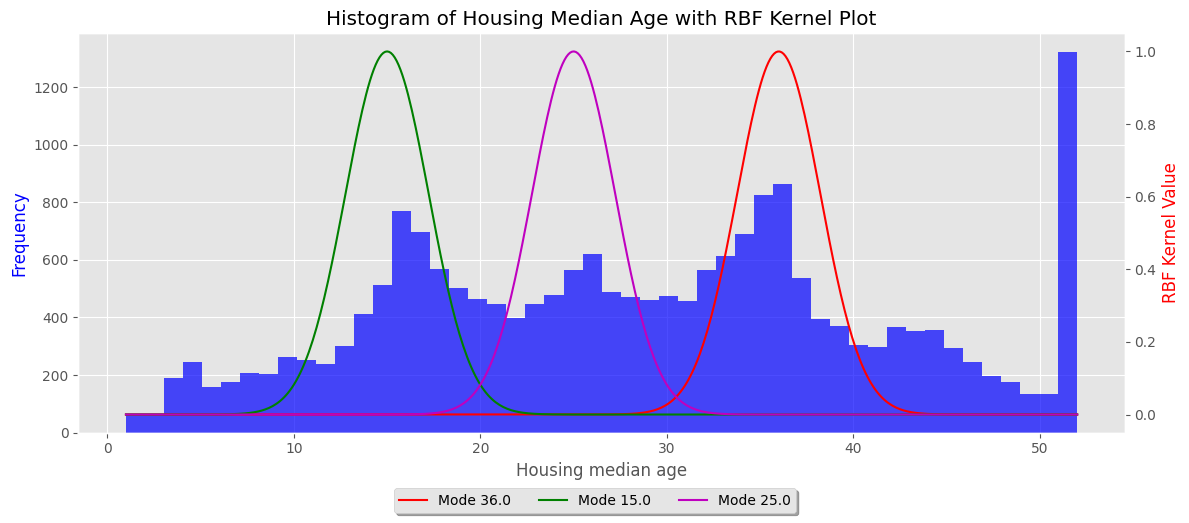

In [222]:
plt.figure(figsize=(12,5))

ax1 = plt.gca()
ax1.hist(x=df['housing_median_age'], bins=50, alpha=0.7, color='b')
ax1.set_xlabel('Housing median age')
ax1.set_ylabel('Frequency', color='b')


ages = np.linspace(df['housing_median_age'].min(), df['housing_median_age'].max(), 500).reshape(-1,1)
rbf_values = rbf_kernel(ages, top_3_modes, gamma=0.1)

ax2 = ax1.twinx()

colors = ['r', 'g', 'm']
for i in range(rbf_values.shape[1]):
    ax2.plot(ages, rbf_values[:, i], color=colors[i], label=f'Mode {top_3_modes[i][0]}')

ax2.set_ylabel('RBF Kernel Value', color='red')

plt.grid(False)
# # Shrink current axis's height by 10% on the bottom
# box = ax2.get_position()
# ax2.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])
fig = plt.gcf()
# Put a legend below current axis
fig.legend(loc='outside lower center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

plt.title('Histogram of Housing Median Age with RBF Kernel Plot')
plt.tight_layout()
plt.show()

In [175]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,avg_persons_per_house,bedroom_ratio,room_ratio,rbf_sf,rbf_la,median_age_simil_36,median_age_simil_15,median_age_simil_25
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,2.555556,0.146591,6.984127,0.999200,0.047735,8.208500e-02,4.382208e-30,7.621865e-12
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,2.109842,0.155797,6.238137,0.999390,0.048861,1.691898e-10,2.732372e-02,2.018965e-01
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,2.802260,0.129516,8.288136,0.999660,0.048473,7.621865e-12,3.508209e-60,2.187420e-32
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,2.547945,0.184458,5.817352,0.999710,0.048093,7.621865e-12,3.508209e-60,2.187420e-32
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,2.181467,0.172096,6.281853,0.999710,0.048093,7.621865e-12,3.508209e-60,2.187420e-32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,2.560606,0.224625,5.045455,0.656075,0.022917,5.559513e-06,4.539993e-05,1.000000e+00
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,3.122807,0.215208,6.114035,0.671682,0.021173,8.489044e-15,4.065697e-01,7.446583e-03
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,2.325635,0.215173,5.205543,0.686644,0.022476,2.098791e-16,6.703200e-01,1.661557e-03
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,2.123209,0.219892,5.329513,0.700515,0.021184,8.489044e-15,4.065697e-01,7.446583e-03
